<a href="https://colab.research.google.com/github/emmaj98/PHY6000-Report/blob/main/Sheffield_2014_SARAH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install numpy pandas>1.0 matplotlib pvlib

In [28]:
from datetime import datetime

from google.colab import files

import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pvlib

In [29]:
plt.rcParams['figure.dpi'] = 120

In [30]:
latitude = 53.381
longitude = -1.486
altitude = 100
tz = "UTC" #IMPORTANT! All dates must be in the same time zone
temperature = 12

In [31]:
url = "https://raw.githubusercontent.com/emmaj98/PHY6000-Report/main/SARAH14SHEFF.csv"
df = pd.read_csv(url,
                 header=3, 
                 index_col="time", 
                 parse_dates=True, 
                 usecols=["time", "irradiance_direct", "irradiance_diffuse"], 
                 )
df = df.tz_localize('UTC')
#This imports only the columns needed into the dataframe and sets the time zone

df["global_h"]=df["irradiance_direct"]+df["irradiance_diffuse"] #Calculate global horizontal irradiance

df = df.resample('m', label="right").mean() #Resample data to chosen time frame

In [32]:
start = df.index[0]
end = df.index[-1]

In [33]:
times = pd.date_range(start = start, end = end, tz = tz, freq = "min") #Create a set of times for solpos
loc = pvlib.location.Location(latitude=latitude, longitude=longitude, altitude=altitude) #Set location
solpos = loc.get_solarposition(times, temperature) #Find position of sun at given times and temp

etr = pvlib.irradiance.get_extra_radiation(times) #Finds irradiance at given times
zen = solpos["apparent_zenith"]
etr_hor = np.cos(np.radians(zen)) * etr #Finds final extraterrestrial radiation at given times and location

In [34]:
etr_hor[etr_hor < 0] = 0 #Ignores negative values
etr_w_hor = etr_hor.resample('m', label="right").mean() #Resample to chosen time frame
df.global_h = df.global_h * 1000 #Rescae global horizontal radiation to correct units

In [35]:
#Calculates KT and ignores certain values
kt = df.global_h / etr_w_hor
kt[kt > 1.3] = np.nan
kt[kt == 0] = np.nan

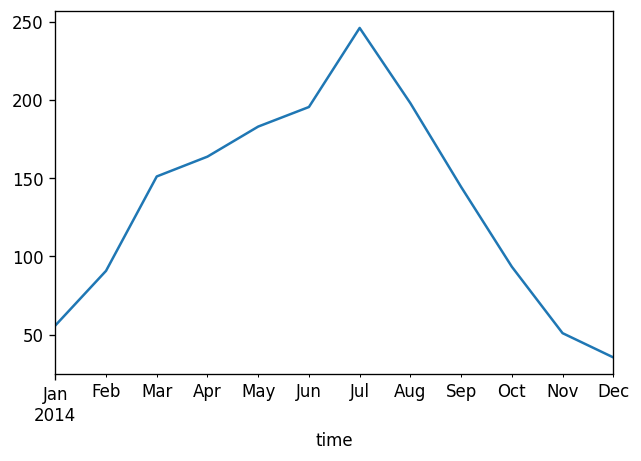

In [36]:
#Plot of global horizontal irradiance against time
df.global_h.plot()
plt.show()

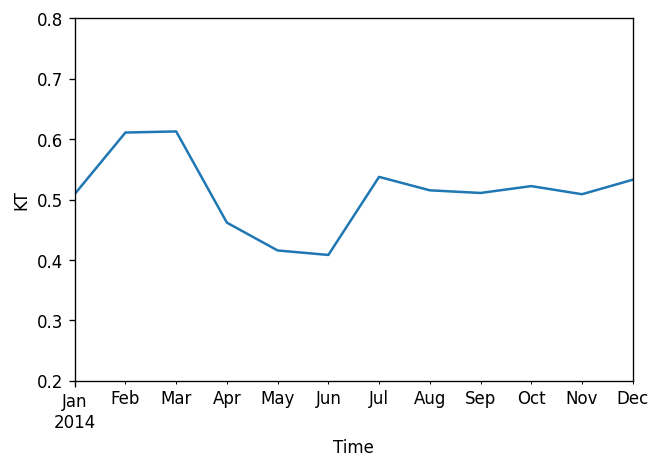

In [37]:
#Plot of KT against time
kt.plot()
plt.xlabel('Time')
plt.ylabel('KT')
plt.ylim([0.2, 0.8])
plt.show()
#plt.savefig('sheffield_sarah_monthly.pdf', dpi=300, bbox_inches = "tight")
#files.download('sheffield_sarah_monthly.pdf')

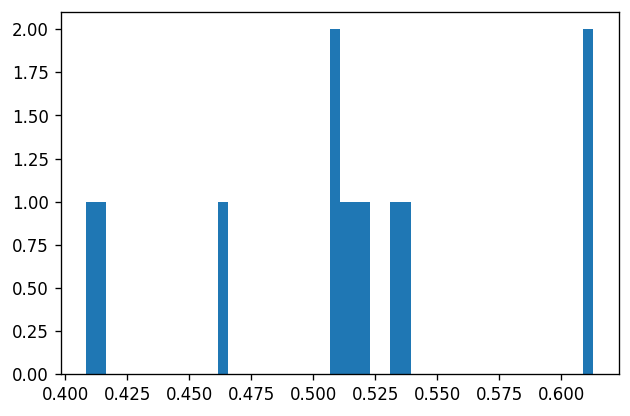

In [38]:
#Histogram of KT distribution
plt.hist(kt[kt.notnull()], bins=50)
plt.show()

In [39]:
#Find mean and standard deviation of KT
ktmean=np.mean(kt)
ktstd=np.std(kt)

print(ktmean)
print(ktstd)

0.5123689848938223
0.06036558149757962
